# Iterables

Some steps in a neuroimaging analysis are repetitive. Running the same preprocessing on multiple subjects or doing statistical inference on multiple files. To prevent the creation of multiple individual scripts, Nipype has as execution plugin for ``Workflow``, called **``iterables``**. 

<img src="../static/images/iterables.png"  width="240">

If you are interested in more advanced procedures, such as synchronizing multiple iterables or using conditional iterables, check out the `synchronize `and `intersource` section in the [`JoinNode`](basic_joinnodes.ipynb) notebook.

## Realistic example

Let's assume we have a workflow with two nodes, node (A) does simple skull stripping, and is followed by a node (B) that does isometric smoothing. Now, let's say, that we are curious about the effect of different smoothing kernels. Therefore, we want to run the smoothing node with FWHM set to 2mm, 8mm, and 16mm.

In [1]:
import os.path as op
from nipype import Node, Workflow

from nipype.interfaces.fsl import BET, IsotropicSmooth

# Initiate a skull stripping Node with BET
skullstrip = Node(BET(mask=True,
                      in_file=op.abspath('data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz')),
                  name="skullstrip")

Create a smoothing Node with IsotropicSmooth

In [2]:
isosmooth = Node(IsotropicSmooth(), name='iso_smooth')

Now, to use ``iterables`` and therefore smooth with different ``fwhm`` is as simple as that:

In [3]:
isosmooth.iterables = ("fwhm", [4, 8, 16])

And to wrap it up. We need to create a workflow, connect the nodes and finally, can run the workflow in parallel.

In [4]:

# Create the workflow
wf = Workflow(name="smoothflow")
wf.base_dir = op.expanduser("output")
wf.connect(skullstrip, 'out_file', isosmooth, 'in_file')

# Run it in parallel (one core for each smoothing kernel)
wf.run('MultiProc', plugin_args={'n_procs': 3})

191104-15:36:37,968 nipype.workflow INFO:
	 Workflow smoothflow settings: ['check', 'execution', 'logging', 'monitoring']
191104-15:36:37,976 nipype.workflow INFO:
	 Running in parallel.
191104-15:36:37,980 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
191104-15:36:38,46 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow.skullstrip" in "/Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/nipype_arcana_workshop/notebooks/output/smoothflow/skullstrip".
191104-15:36:38,61 nipype.workflow INFO:
	 [Node] Running "skullstrip" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/nipype_arcana_workshop/notebooks/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz /Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/nipype_arcana_workshop/notebooks/output/smoothflow/skullstrip/sub-01_ses-test_T1w_b

**Note**, that ``iterables`` is set on a specific node (``isosmooth`` in this case), but ``Workflow`` is needed to expend the graph to three subgraphs with three different versions of the ``isosmooth`` node.

If we visualize the graph with ``exec``, we can see where the parallelization actually takes place.

191104-15:36:56,306 nipype.workflow INFO:
	 Generated workflow graph: /Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/nipype_arcana_workshop/notebooks/output/smoothflow/graph.png (graph2use=exec, simple_form=True).


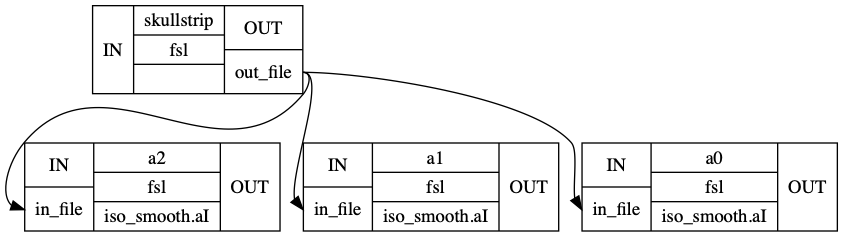

In [5]:
# Visualize the detailed graph
from IPython.display import Image
wf.write_graph(graph2use='exec', format='png', simple_form=True)
Image(filename=op.abspath('output/smoothflow/graph_detailed.png'))

If you look at the structure in the workflow directory, you can also see, that for each smoothing, a specific folder was created, i.e. ``_fwhm_16``.

In [6]:
!tree  output/smoothflow -I '*txt|*pklz|report*|*.json|*js|*.dot|*.html'

output/smoothflow
├── _fwhm_16
│   └── iso_smooth
│       ├── _report
│       └── sub-01_ses-test_T1w_brain_smooth.nii.gz
├── _fwhm_4
│   └── iso_smooth
│       ├── _report
│       └── sub-01_ses-test_T1w_brain_smooth.nii.gz
├── _fwhm_8
│   └── iso_smooth
│       ├── _report
│       └── sub-01_ses-test_T1w_brain_smooth.nii.gz
├── graph.png
├── graph_detailed.png
└── skullstrip
    ├── _report
    └── sub-01_ses-test_T1w_brain.nii.gz

11 directories, 6 files


Now, let's visualize the results!

In [7]:
from nilearn import plotting
%matplotlib inline

/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


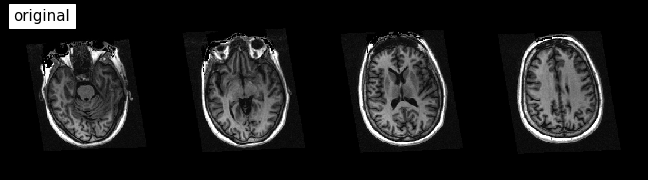

In [8]:
plotting.plot_anat(
    'data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz', title='original',
    display_mode='z', dim=-1, cut_coords=(-50, -35, -20, -5), annotate=False);

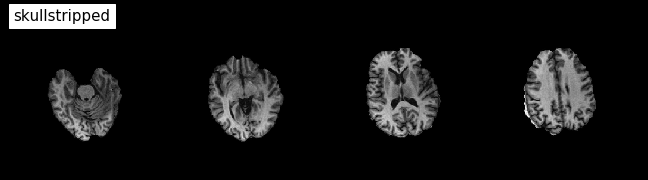

In [12]:
plotting.plot_anat(
    'output/smoothflow/skullstrip/sub-01_ses-test_T1w_brain.nii.gz', title='skullstripped',
    display_mode='z', dim=-1, cut_coords=(-50, -35, -20, -5), annotate=False);

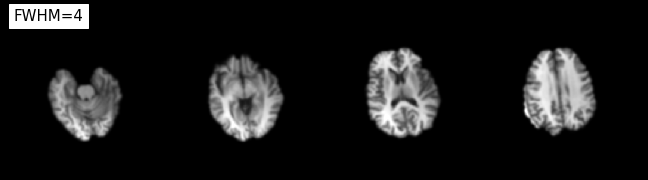

In [13]:
plotting.plot_anat(
    'output/smoothflow/_fwhm_4/iso_smooth/sub-01_ses-test_T1w_brain_smooth.nii.gz', title='FWHM=4',
    display_mode='z', dim=-0.5, cut_coords=(-50, -35, -20, -5), annotate=False);

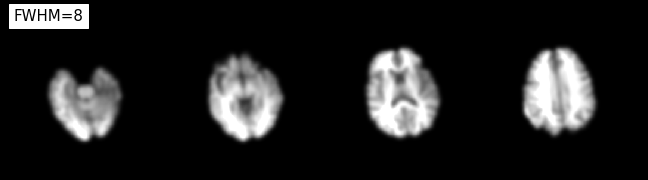

In [14]:
plotting.plot_anat(
    'output/smoothflow/_fwhm_8/iso_smooth/sub-01_ses-test_T1w_brain_smooth.nii.gz', title='FWHM=8',
    display_mode='z', dim=-0.5, cut_coords=(-50, -35, -20, -5), annotate=False);

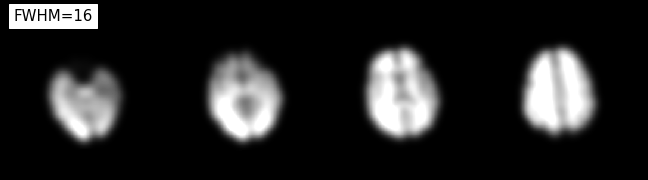

In [15]:
plotting.plot_anat(
    'output/smoothflow/_fwhm_16/iso_smooth/sub-01_ses-test_T1w_brain_smooth.nii.gz', title='FWHM=16',
    display_mode='z', dim=-0.5, cut_coords=(-50, -35, -20, -5), annotate=False);

# ``IdentityInterface`` (special use case of ``iterables``)

We often want to start our worflow from creating subgraphs, e.g. for running preprocessing for all subjects. We can easily do it with setting ``iterables`` on the ``IdentityInterface``. The ``IdentityInterface`` interface allows you to create ``Nodes`` that does simple identity mapping, i.e. ``Nodes`` that only work on parameters/strings.


For example, you want to start your workflow by collecting anatomical files for 5 subjects.

In [16]:
# First, let's specify the list of subjects
subject_list = ['01', '02', '03', '04', '05']

Now, we can create the IdentityInterface Node

In [17]:
from nipype import IdentityInterface
infosource = Node(IdentityInterface(fields=['subject_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

That's it. Now, we can connect the output fields of this ``infosource`` node to ``SelectFiles`` and ``DataSink`` nodes.

In [18]:
from os.path import join as opj, expanduser
from nipype.interfaces.io import SelectFiles, DataSink

anat_file = opj('sub-{subject_id}', 'ses-test', 'anat', 'sub-{subject_id}_ses-test_T1w.nii.gz')

templates = {'anat': anat_file}

selectfiles = Node(SelectFiles(templates,
                               base_directory=op.abspat'data/ds000114'),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=expanduser("output"),
                         container="datasink"),
                name="datasink")

wf_sub = Workflow(name="choosing_subjects")
wf_sub.connect(infosource, "subject_id", selectfiles, "subject_id")
wf_sub.connect(selectfiles, "anat", datasink, "anat_files")
wf_sub.run()

191104-15:38:14,911 nipype.workflow INFO:
	 Workflow choosing_subjects settings: ['check', 'execution', 'logging', 'monitoring']
191104-15:38:14,930 nipype.workflow INFO:
	 Running serially.
191104-15:38:14,931 nipype.workflow INFO:
	 [Node] Setting-up "choosing_subjects.selectfiles" in "/private/tmp/tmpzpoax_8z/choosing_subjects/_subject_id_05/selectfiles".
191104-15:38:14,934 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
191104-15:38:14,940 nipype.workflow WARNING:
	 [Node] Error on "choosing_subjects.selectfiles" (/private/tmp/tmpzpoax_8z/choosing_subjects/_subject_id_05/selectfiles)
191104-15:38:14,942 nipype.workflow ERROR:
	 Node selectfiles.a4 failed to run on host calcium.mbi.monash.edu.au.
191104-15:38:14,944 nipype.workflow ERROR:
	 Saving crash info to /Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/nipype_arcana_workshop/notebooks/crash-20191104-153814-tclose-selectfiles.a4-f9e344bd-8a6e-4dfa-8257-18b49605c482.pklz
Tr

191104-15:38:14,990 nipype.workflow WARNING:
	 [Node] Error on "choosing_subjects.selectfiles" (/private/tmp/tmpv20pj5_t/choosing_subjects/_subject_id_01/selectfiles)
191104-15:38:14,992 nipype.workflow ERROR:
	 Node selectfiles.a0 failed to run on host calcium.mbi.monash.edu.au.
191104-15:38:14,994 nipype.workflow ERROR:
	 Saving crash info to /Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/nipype_arcana_workshop/notebooks/crash-20191104-153814-tclose-selectfiles.a0-84fb8b44-093b-4a7c-8127-57417d263f32.pklz
Traceback (most recent call last):
  File "/Users/tclose/git/ni/nipype/nipype/pipeline/plugins/linear.py", line 48, in run
    node.run(updatehash=updatehash)
  File "/Users/tclose/git/ni/nipype/nipype/pipeline/engine/nodes.py", line 472, in run
    result = self._run_interface(execute=True)
  File "/Users/tclose/git/ni/nipype/nipype/pipeline/engine/nodes.py", line 563, in _run_interface
    return self._run_command(execute)
  File "/Users/tclose/git/ni/nipype/nipype/p

RuntimeError: Workflow did not execute cleanly. Check log for details

Now we can check that five anatomicl images are in ``anat_files`` directory:

In [ ]:
! ls -lh  output/datasink/anat_files/

This was just a simple example of using ``IdentityInterface``, but a complete example of preprocessing workflow you can find in [Preprocessing Example](example_preprocessing.ipynb)).

## Exercise 1
Create a workflow to calculate various powers of ``2`` using  two nodes, one for ``IdentityInterface`` with ``iterables``, and one for ``Function`` interface to calculate the power of ``2``.

In [ ]:
# write your solution here

In [ ]:
# lets start from the Identity node
from nipype import Function, Node, Workflow
from nipype.interfaces.utility import IdentityInterface

iden = Node(IdentityInterface(fields=['number']), name="identity")
iden.iterables = [("number", range(8))]

In [ ]:
# the second node should use the Function interface
def power_of_two(n):
    return 2**n

# Create Node
power = Node(Function(input_names=["n"],
                      output_names=["pow"],
                      function=power_of_two),
              name='power')

In [ ]:
#and now the workflow
wf_ex1 = Workflow(name="exercise1")
wf_ex1.connect(iden, "number", power, "n")
res_ex1 = wf_ex1.run()

# we can print the results
for i in range(8):
    print(list(res_ex1.nodes())[i].result.outputs)